# Medical Costs Dataset Analysis
**Author:** Trent Rueckert  
**Date:** April 19, 2025  
**Objective:** Analyze the Medical Costs dataset to predict insurance charges based on age, BMI, and smoking status.

## Introduction
In this notebook, I will analyze the Medical Costs dataset to predict insurance charges by preparing/exploring the data, cleaning the data/handling missing values, performing feature engineering, and training machine learning models based on different selected features. More specifically, I will be using various regression models to provide insights on which features most impact fare price. My focus will be on the features: age, BMI, and smoker.

## Imports
Import the necessary libraries with the code below.

In [26]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

## Section 1. Import and Inspect the Data
### 1.1 Load the dataset and display the first 10 rows

In [2]:
# Load the dataset
medical_costs = pd.read_csv('data/insurance.csv')

# Display the first 10 rows
medical_costs.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 1.2 Check for missing values and display summary statistics

In [3]:
# Check for missing values
print('Missing Values:')
print(medical_costs.isnull().sum())

Missing Values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [4]:
# Display summary statistics for numerical columns
print('Summary Statistics (Numerical):')
print(medical_costs.describe(), '\n')

# Display summary statistics for categorical columns
print('Summary Statistics (Categorical):')
print(medical_costs.describe(include=['object']))

Summary Statistics (Numerical):
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010 

Summary Statistics (Categorical):
         sex smoker     region
count   1338   1338       1338
unique     2      2          4
top     male     no  southeast
freq     676   1064        364


### Reflection 1:
What do you notice about the dataset?
* There are no missing values.
* There are slightly more males (676) than females (662).
* There are 1064 non smokers and 274 smokers.
* There is a possible outlier shown at the maximum in the charges column, and the range is very wide.

Are there any data issues?
* There appear to be no issues with the data except a potential outlier in the charges column.

## Section 2. Data Exploration and Preparation
### 2.1 Explore data patterns and distributions
#### 2.1.1 Create histograms, boxplots, and count plots for categorical variables

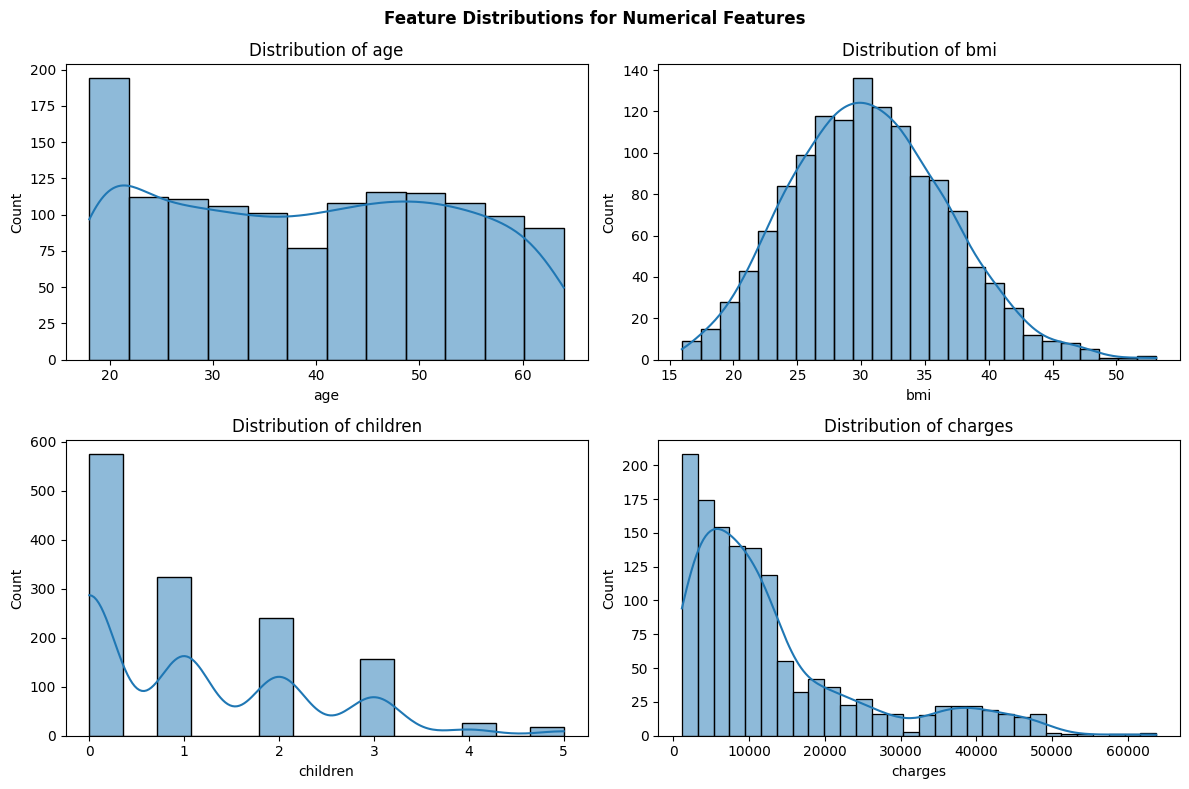

In [5]:
# Extract just the numeric columns 
num_cols = medical_costs.select_dtypes(include='number').columns

plt.figure(figsize=(12,8))

# Create the histrograms of distributions
for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i + 1)
    sns.histplot(medical_costs[col], kde=True)
    plt.title(f'Distribution of {col}')

# Add an overall title and show the charts
plt.suptitle('Feature Distributions for Numerical Features', fontweight='bold')
plt.tight_layout()
plt.show()

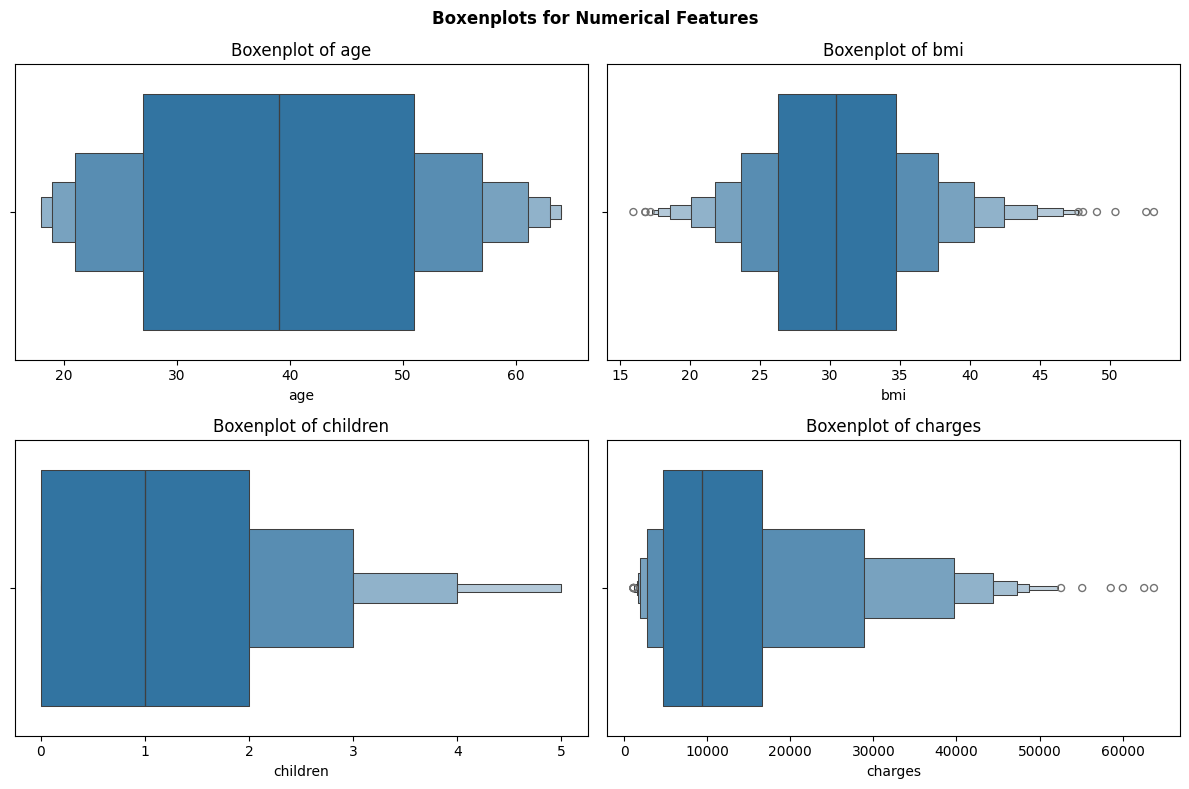

In [6]:
# Create the figure
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()

# Create boxenplots for the numeric columns
for i, col in enumerate(num_cols):
    sns.boxenplot(data=medical_costs, x=col, ax=axes[i])
    axes[i].set_title(f'Boxenplot of {col}')

# Add an overall title and show the charts
plt.suptitle('Boxenplots for Numerical Features', fontweight='bold')
plt.tight_layout()
plt.show()

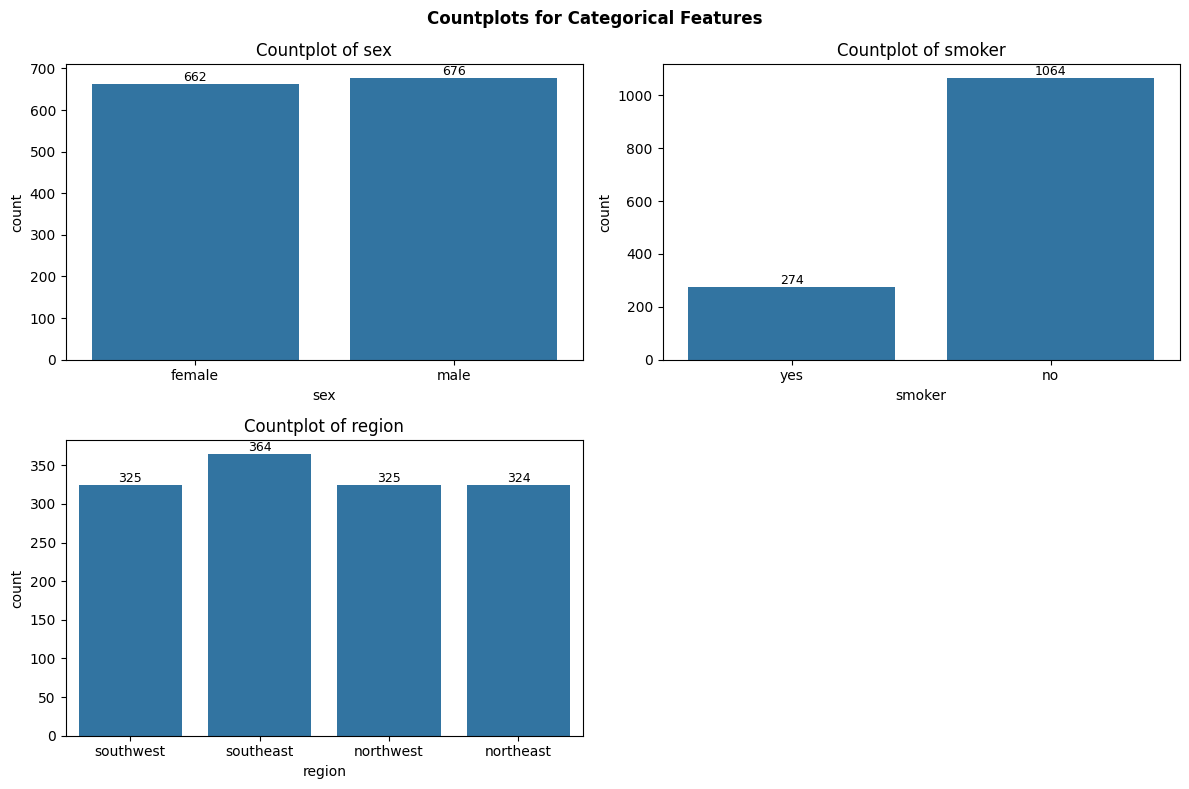

In [7]:
# Extract the categorical columns
cat_cols = medical_costs.select_dtypes(include=['object']).columns

# Create the figure
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()

# Create countplots for the categorical columns
for i, col in enumerate(cat_cols):
    sns.countplot(data=medical_costs, x=col, ax=axes[i])
    axes[i].set_title(f'Countplot of {col}')

    # Annotate bars with count labels
    for p in axes[i].patches:
        count = int(p.get_height())
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[i].annotate(str(count), (x, y), ha='center', va='bottom', fontsize=9)

# Remove any unused subplots
for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])

# Add an overall title and show the charts
plt.suptitle('Countplots for Categorical Features', fontweight='bold')
plt.tight_layout()
plt.show()

#### 2.1.2 Identify patterns, outliers, and anomalies in feature distributions

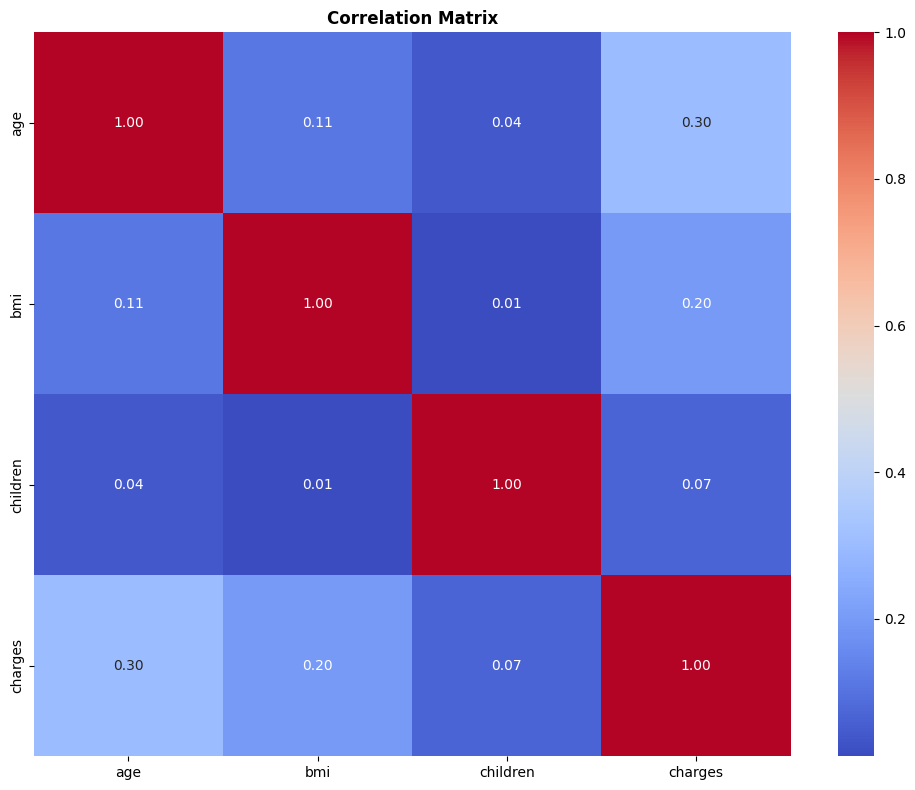

In [8]:
# Extract just the numeric columns 
num_cols = medical_costs.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = num_cols.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)

# Add an overall title and show the charts
plt.title('Correlation Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

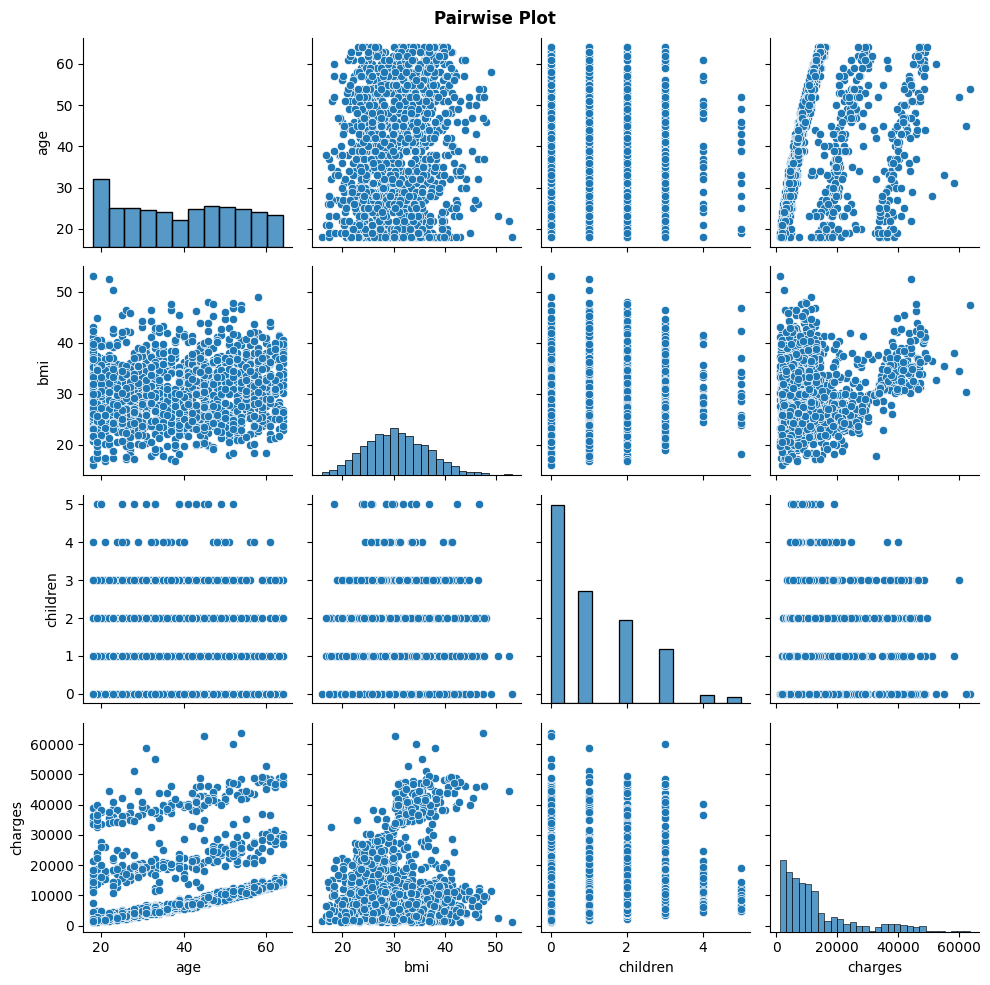

In [9]:
# Create a pairwise plot for numerical features
sns.pairplot(medical_costs)

# Add an overall title and show the charts
plt.suptitle("Pairwise Plot", fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
# Extract just the numeric columns 
num_cols = medical_costs.select_dtypes(include='number')

# Using IQR method to detect outliers for numeric columns
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1

# Define outlier condition for each column
outlier_condition = ((num_cols < (Q1 - 1.5 * IQR)) | (num_cols > (Q3 + 1.5 * IQR)))

# Count the number of outliers for each column
outlier_count = outlier_condition.sum()

# Print results
print("\nOutlier count for each column:")
print(outlier_count)


Outlier count for each column:
age           0
bmi           9
children      0
charges     139
dtype: int64


#### 2.1.3 Check for class imbalance in the target variable
There is no class imbalance as the target variable (charges) is numerical and there are no classes. Thus there is no need to check for class imbalance.

### 2.2 Handle missing values and clean data
#### 2.2.1 Impute or drop missing values
* There are none.

#### 2.2.2 Remove or transform outliers 
* bmi: 9 
* charges: 139

In [11]:
# Transform charges with log1p (log(1 + x))
medical_costs['log_charges'] = np.log1p(medical_costs['charges'])

#### 2.2.3 Convert categorical data to numerical format using encoding

In [12]:
# Encode 'smoker' column manually (smoker = 1, non-smoker = 0)
medical_costs['smoker_encoded'] = medical_costs['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

### 2.3 Feature selection and engineering
#### 2.3.1 Create new features

In [13]:
medical_costs['age_bmi_interaction'] = medical_costs['age'] * medical_costs['bmi']

#### 2.3.2 Transform or combine existing features to improve model performance
* I am technically not transforming or combining existing features, but creating a new one above.

#### 2.3.3 Scale or normalize data

In [14]:
# Standardization
scaler = StandardScaler()
medical_costs[['age_scaled', 'bmi_scaled']] = scaler.fit_transform(medical_costs[['age', 'bmi']])

In [15]:
# Show a few rows with new columns
display(medical_costs.head())

,age,sex,bmi,children,smoker,region,charges,log_charges,smoker_encoded,age_bmi_interaction,age_scaled,bmi_scaled
0,19,female,27.900,0,yes,southwest,16884.92400,9.734236,1,530.100,-1.438764,-0.453320
1,18,male,33.770,1,no,southeast,1725.55230,7.453882,0,607.860,-1.509965,0.509621
2,28,male,33.000,3,no,southeast,4449.46200,8.400763,0,924.000,-0.797954,0.383307
3,33,male,22.705,0,no,northwest,21984.47061,9.998137,0,749.265,-0.441948,-1.305531
4,32,male,28.880,0,no,northwest,3866.85520,8.260455,0,924.160,-0.513149,-0.292556


### Reflection 2: 
What patterns or anomalies do you see? 
* There appears to be 3 tiers of charges as age increases.
* There are a lot of outliers in the target variable (Charges).
* Charges seem to decrease with more children.
* None of the numerical columns are very correlated with charges, or one another.

Do any features stand out? 
* If I had to choose one, it would be age.
* There are a lot of people around age 20, which could explain so many non-smokers.
* The majority of the people are about mid 20s to early 50s.

What preprocessing steps were necessary to clean and improve the data? 
* Identifying and log transforming the outliers in the target variable (charges). The bmi outliers were kept.
* Encoding the smoker column to 1 for yes and 0 for no.

Did you create or modify any features to improve performance?
* Created a new feature, age_bmi_interaction, to record the interaction between age and bmi.
* Created a new feature, smoker_encoded, with the prior categorical values with numeric ones.
* Created new features, age_scaled and bmi_scaled, to scale age and bmi to be on similar scales to improve model performance.

## Section 3. Feature Selection and Justification
### 3.1 Choose features and target

#### 3.1.1 Select two or more input features
* My input features will be age_scaled, bmi_scaled, and smoker_encoded

#### 3.1.2 Select a target variable 
Regression: Continuous target variable (e.g., price, temperature).
Classification: Categorical target variable (e.g., gender, species).
Clustering: No target variable.

* I will be using log_charges.

#### 3.1.3 Justify your selection with reasoning
* I will be using the input features that I have scaled or encoded because:
  * Age is typically correlated with insurances charges, as age increases, charges increase.
  * BMI is typically correlated with insurances charges because the higher BMI a person has, the more likely they are to have health issues.
  * Smoking status is typically correlated because smoking also leads to a higher likelihood of health issues.

### 3.2 Define X and y

In [16]:
# Define X (input features)
X = medical_costs[['age_scaled', 'bmi_scaled', 'smoker_encoded']]

# Define y (target variable)
y = medical_costs['log_charges']

### Reflection 3: 
Why did you choose these features? 
* I chose age and bmi because they are the most correlated to charges in the correlation matrix heatmap.
* I chose smoking status because I believe it will behave similarly to bmi.

How might they impact predictions or accuracy?
* They should help create better predictions with higher accuracy.

## Section 4. Train a Model (Linear Regression)
### 4.1 Split the data into training and test sets using train_test_split

In [20]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show set sizes
print('Train size:', len(X_train))
print('Test size:', len(X_test), "\n")

Train size: 1070
Test size: 268 



### 4.2 Train model using Scikit-Learn model.fit() method

In [21]:
# Create the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

LinearRegression()

### 4.3 Evalulate performance, for example:
* Regression: R^2, MAE, RMSE (RMSE has been recently updated)
* Classification: Accuracy, Precision, Recall, F1-score, Confusion Matrix
* Clustering: Inertia, Silhouette Score

In [23]:
# Make predictions using the trained model
y_pred = model.predict(X_test)

# Calculate R² (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)
# Display the R² value
print(f"R² Score: {r2:.2f}", "\n")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
# Display the MAE value
print(f"Mean Absolute Error (MAE): {mae:.2f}", "\n")

# Calculate Root Mean Squared Error (RMSE)
rmse = root_mean_squared_error(y_test, y_pred)
# Display the RMSE value
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}", "\n")

R² Score: 0.77 

Mean Absolute Error (MAE): 0.30 

Root Mean Squared Error (RMSE): 0.45 



In [ ]:
# Show the effect of each feature
print(model.coef_)
print(X.columns)

[0.48911521 0.06797889 1.54841241]
Index(['age_scaled', 'bmi_scaled', 'smoker_encoded'], dtype='object')


### Reflection 4: 
How well did the model perform? 
* It peformed pretty well. 77% explained variance is a decent number for 3 input features, but I would've liked it to be higher.
* Based on the MAE and accounting for the log transformation, predicted charges could be ~35% higher or lower than actual charges.
* Based on the RMSE and accounting for the log transformation, typical larger errors are ~57% off.
* Overall, it looks like the model has a lot of potential variance, and doesn't predict as well as expected, although not too bad.

Any surprises in the results?
* Smoking status had the far and away highest effect on insurance charges.
* I thought BMI would have more of an impact, but it is miniscule compared to smoking status. 
* I expected age and BMI to be closer, but age was much better.
* Overall, I thought the model would perform better, but I am not disappointed with the results.

## Section 5. Improve the Model or Try Alternates (Implement Pipelines)
### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression

In [ ]:
# Define features and target
X1 = medical_costs[['age', 'bmi', 'smoker_encoded']]
y1 = medical_costs['log_charges']

# Split the data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Build pipeline 1
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit the pipeline on training data
pipeline.fit(X1_train, y1_train)

# Predict
y_pred1 = pipeline.predict(X1_test)

# Calculate R² (Coefficient of Determination)
r2p1 = r2_score(y1_test, y_pred1)
# Display the R² value
print(f"R² Score: {r2p1:.2f}", "\n")

# Calculate Mean Absolute Error (MAE)
maep1 = mean_absolute_error(y1_test, y_pred1)
# Display the MAE value
print(f"Mean Absolute Error (MAE): {maep1:.2f}", "\n")

# Calculate Root Mean Squared Error (RMSE)
rmsep1 = root_mean_squared_error(y1_test, y_pred1)
# Display the RMSE value
print(f"Root Mean Squared Error (RMSE): {rmsep1:.2f}", "\n")

R² Score: 0.77 

Mean Absolute Error (MAE): 0.30 

Root Mean Squared Error (RMSE): 0.45 



### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression

In [28]:
# Build pipeline 2
pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit the pipeline on training data
pipeline2.fit(X1_train, y1_train)

# Predict
y_pred2 = pipeline2.predict(X1_test)

# Calculate R² (Coefficient of Determination)
r2p2 = r2_score(y1_test, y_pred2)
# Display the R² value
print(f"R² Score: {r2p2:.2f}", "\n")

# Calculate Mean Absolute Error (MAE)
maep2 = mean_absolute_error(y1_test, y_pred2)
# Display the MAE value
print(f"Mean Absolute Error (MAE): {maep2:.2f}", "\n")

# Calculate Root Mean Squared Error (RMSE)
rmsep2 = root_mean_squared_error(y1_test, y_pred2)
# Display the RMSE value
print(f"Root Mean Squared Error (RMSE): {rmsep2:.2f}", "\n")

R² Score: 0.83 

Mean Absolute Error (MAE): 0.23 

Root Mean Squared Error (RMSE): 0.39 



### 5.3 Compare performance of all models across the same performance metrics

In [30]:
# Create a comparison table
metrics_df = pd.DataFrame({
    'Metric': ['R²', 'MAE', 'RMSE'],
    'Manual Linear': [r2, mae, rmse],
    'Pipeline 1':    [r2p1, maep1, rmsep1],
    'Pipeline 2':    [r2p2, maep2, rmsep2]
})

# Round to 3 decimal places
metrics_df = metrics_df.round(3)

# Show the table
print(metrics_df)

  Metric  Manual Linear  Pipeline 1  Pipeline 2
0     R²          0.771       0.771       0.831
1    MAE          0.299       0.299       0.233
2   RMSE          0.454       0.454       0.389


### Reflection 5: 
Which models performed better? 
* The polynomial features pipeline performed the best with the highest R<sup>2</sup>, a lower MAE so better average accuracy, and a lower RMSE so fewer larger mistakes.
* The manual linear regression model from section 4 performed exactly the same as pipeline 1, likely due to already scaling in the manual one, and both performed worse than pipeline 2.

How does scaling impact results?
* It helps prevent features on larger values from overpowering the other features.

## Section 6. Final Thoughts & Insights
### 6.1 Summarize findings
* Overall, I was fine with how my results turned out. I expected to have better results when scaling age and bmi, and log transforming the insurance charges to alleviate the outliers, but regardless I thought it went well. Age and smoker were both great features to use, while bmi wasn't as much. The pipeline with polynomial features peformed the best out of the 3 models, which makes sense because it can capture the non-linear relationships between the features. These findings make sense from a practical standpoint as well because we would expect age and smoking status to impact the insurance charges. BMI however, in itself, is somewhat of a flawed metric, so it makes sense for it not to have as much of an impact.

### 6.2 Discuss challenges faced
* Making decisions on outliers was tough because some outliers appeared worse than others in the boxenplots, but I erred on the side of caution since I was dealing with outliers in the target variable. It was hard to tell how extreme the outliers were before opting for the log transformation. 
* I had an issue when I encoded smoker because instead of 'yes' or 'no' I encoded 1 as 'smoker' and when I displayed the head I noticed it wasn't matching. It was a pretty simple fix and it is a good thing I checked before moving on further.

### 6.3 If you had more time, what would you try next?
* I would like to see if I could try this again without BMI, or try different combinations of features.
* I would try and dive deeper to see if there were more ways to optimize the models' performances.

### Reflection 6: 
What did you learn from this project?
* There are so many different models and approaches with the same end goal in mind. We demonstrated how there are multiple pipelines that provide different results. I am sure there is even more we could do on a dataset that is much larger than this. Structure for a project like this is huge. I found myself at times getting lost in my own work and then thoughts. Overall, projects like this just reinforce my love all things data.